# 당뇨병 발병 예측 - Gaussian Naive Bayes 모델

이 글에서는 피마 인디언 당뇨병 데이터세트를 사용하여 어떻게 당뇨병 발병을 예측할 수 있는지 베이지안 추론 방식으로 보여줍니다. 이 글의 전개 과정은 아래와 같습니다. 

1. 당뇨병 발병 데이터세트를 준비합니다.
2. 발병 여부별로 측정값의 히스토그램을 그려서 분포를 파악합니다.
3. 발병 여부에 따라서 측정값이 어떻게 분포할 수 있는지 설명하는 모델을 정의합니다.
4. 측정값이 주어질 때 발병 여부를 예측하는 분류기를 구현합니다.
5. 데이터 세트를 훈련 데이터와 검증 데이터로 나누어 분류기를 훈련시키고 예측 성능을 구합니다.

## 라이브러리 준비

사용할 파이썬 라이브러리들을 임포트합니다.

In [23]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=6)
np.random.seed(7)

## 데이터 준비

**UCI Machine Learning**에서 제공하는 [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data)를 사용하여 데이터세트를 준비합니다.

* 9개의 속성을 가지고 있음
  * 측정 항목(measured)
    * Pregnancies
    * Glucose
    * BloodPressure
    * SkinThickness
    * Insulin
    * BMI
    * DiabetesPedigreeFunction
    * Age
  * 예측 항목(target)
    * Outcome

### 데이터 읽기

In [24]:
ds_diabetes = pd.read_csv('datasets_228_482_diabetes.csv')

ds_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 데이터 탐색

### 데이터 통계

측정 데이터별 통계 자료는 아래와 같습니다.

In [25]:
ds_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 발병 여부별 측정값의 히스토그램

발병 여부별로 측정값의 히스토그램을 그립니다. 이것을 참고하여 발병 여부에 따라 측정값이 어떤 분포를 따르는지 추정할 수 있습니다.

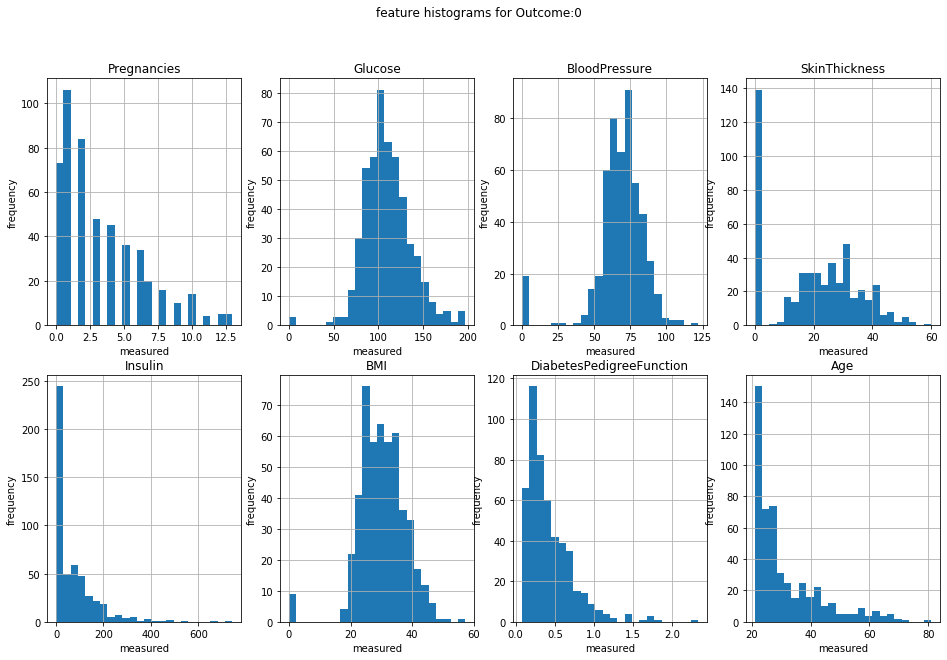

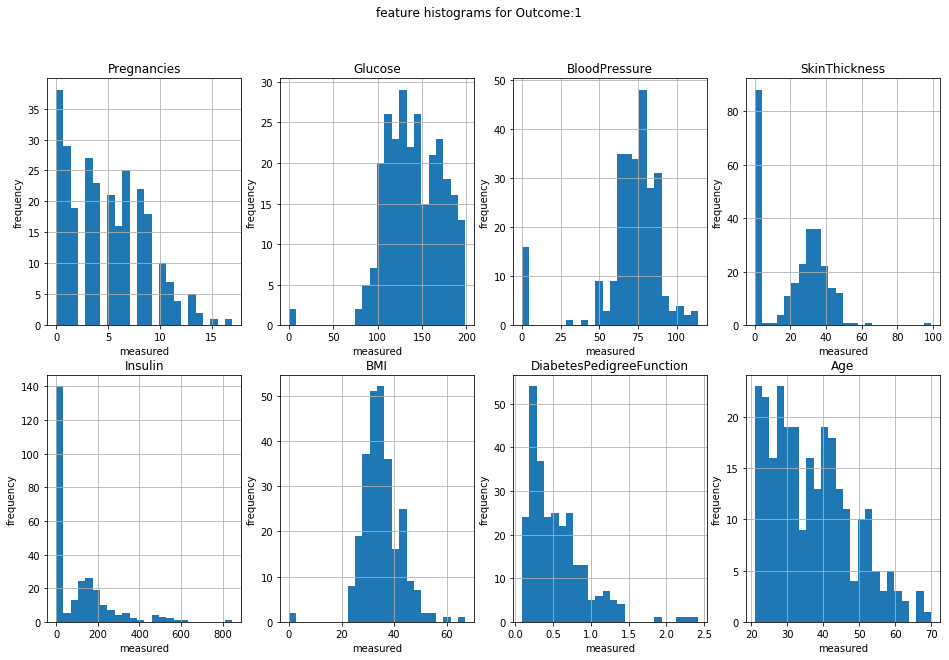

In [26]:
def separate_by_targets(X, y):
    separated = defaultdict(lambda: [])
    
    row_count = X.shape[0]
    for row in np.arange(row_count):
        measured = X[row, :]
        target = y[row]
        separated[target].append(measured)
    
    for target in separated.keys():
        separated[target] = np.array(separated[target])
        
    return separated

def plot_feature_histograms_for_a_target(separated, target, feature_names, target_name, bin_count):
    ds_measured = separated[target]
    
    fig = plt.figure(figsize = (16,10))
    fig.suptitle(f'feature histograms for {target_name}')
    for col in np.arange(len(feature_names)):
        plt.subplot(241 + col)
        plt.hist(ds_measured[:, col], bins=bin_count)
        plt.grid(True)
        plt.xlabel('measured')
        plt.ylabel('frequency')
        plt.title(feature_names[col])
    plt.show()
    
separated = separate_by_targets(ds_diabetes.iloc[:,0:8].values, ds_diabetes.iloc[:,8].values)
for target in np.arange(len(separated.keys())):
    feature_names = ds_diabetes.columns[0:8]
    target_name = 'Outcome:' + str(target)
    plot_feature_histograms_for_a_target(separated, target, feature_names, target_name, 24)

위의 히스토그램에서 발병 여부별로 측정값의 분포를 정규분포로 간주하는 것은 일부 속성의 경우에는 무리가 없어 보이지만 그렇지 않은 속성들도 있음을 알 수 있습니다. 그럼에도 불구하고 모든 속성이 정규분포를 따른다고 가정했을 때 어느 정도의 예측 정확도를 보여 줄 것인지 확인해 볼 수 있습니다.

### 발병 여부별 측정값의 상자그림

발병 여부에 따라 측정값의 통계가 어떻게 달라지는지 더 명확하게 파악하기 위하여 발병 여부별로 측정값의 상자그림을 그려봅니다.

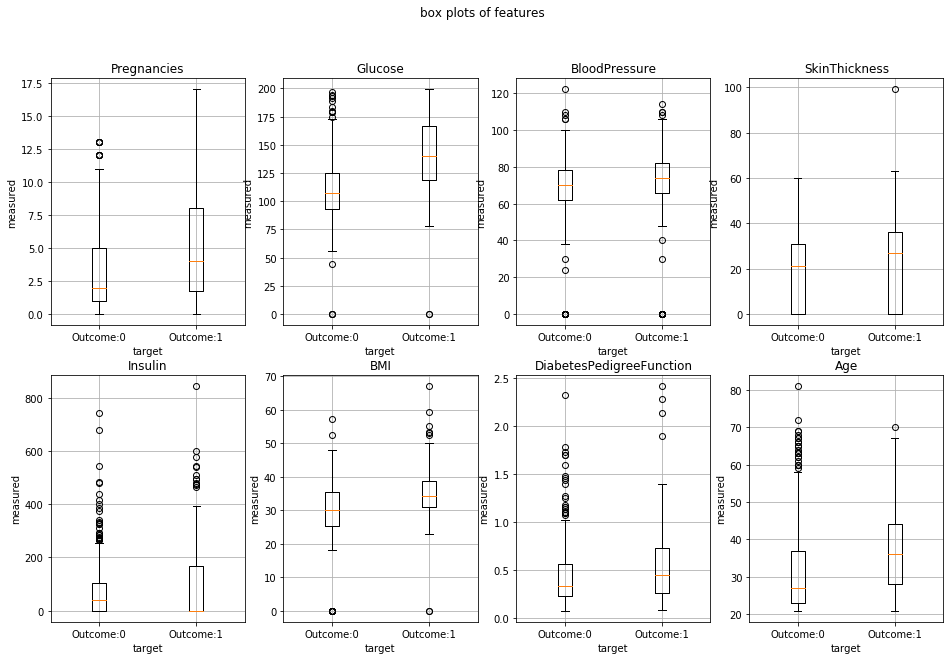

In [27]:
feature_names = ds_diabetes.columns[0:8]
target_names = {0:'Outcome:0', 1:'Outcome:1'}

plt.figure(figsize = (16,10))
plt.suptitle('box plots of features')
for col in np.arange(len(feature_names)):
    plt.subplot(241 + col)
    data_for_boxplot = []
    labels = []
    for target in np.arange(len(separated.keys())):
        data_for_boxplot.append(separated[target][:, col])
        labels.append(target_names[target])
    plt.boxplot(data_for_boxplot, labels = labels)
    plt.grid(True)
    plt.xlabel('target')
    plt.ylabel('measured')
    plt.title(f'{feature_names[col]}')
plt.show()

위의 상자그림들로부터 포도당(glucose) 수치가 당뇨병 발병 여부를 예측하는데 가장 중요하게 쓰일 수 있음을 알 수 있습니다.

## 모델 정의

**발병 여부에 따른 측정값의 분포**를 설명하기 위하여 모델을 정의합니다. 여기에서는 발병 여부가 주어질 때 측정을 수행하여 얻는 값들의 발생 가능성이 아래의 분포를 따른다고 가정합니다.

* 조사대상군으로부터 수집한 데이터에서 구한 발병 여부별 측정값 평균과 표준편차를 사용하는 정규분포

예를 들어 당뇨병이 발병했을 때 포도당 수치에 해당하는 값들의 발생 가능성이 어떻게 분포하는지는 아래의 방법으로 구합니다.

1. 데이터세트에서 **당뇨병 발병**에 해당하는 것들만 따로 모읍니다.
2. **포도당** 값들의 평균과 표준편차를 구합니다.
3. 위에서 구한 평균과 표준편차를 사용하는 정규분포를 그립니다. 

이제 발병 여부별 측정값 평균과 표준편차를 구하여 테이블 형태로 저장합니다.

In [28]:
def get_norm_params(separated):
    targets = separated.keys()
    target_count = len(targets)
    feature_count = separated[0].shape[1]

    thetas = np.zeros((target_count, feature_count))
    sigmas = np.zeros((target_count, feature_count))
    
    for target in targets:
        ds_measured = separated[target]
        thetas[target,:] = np.mean(ds_measured, axis=0)
        sigmas[target,:] = np.std(ds_measured, axis=0)
        
    return thetas, sigmas

thetas, sigmas = get_norm_params(separated)

위에서 구한 평균과 표준편차 값들을 사용하여 정규분포 곡선을 그려 봅니다.

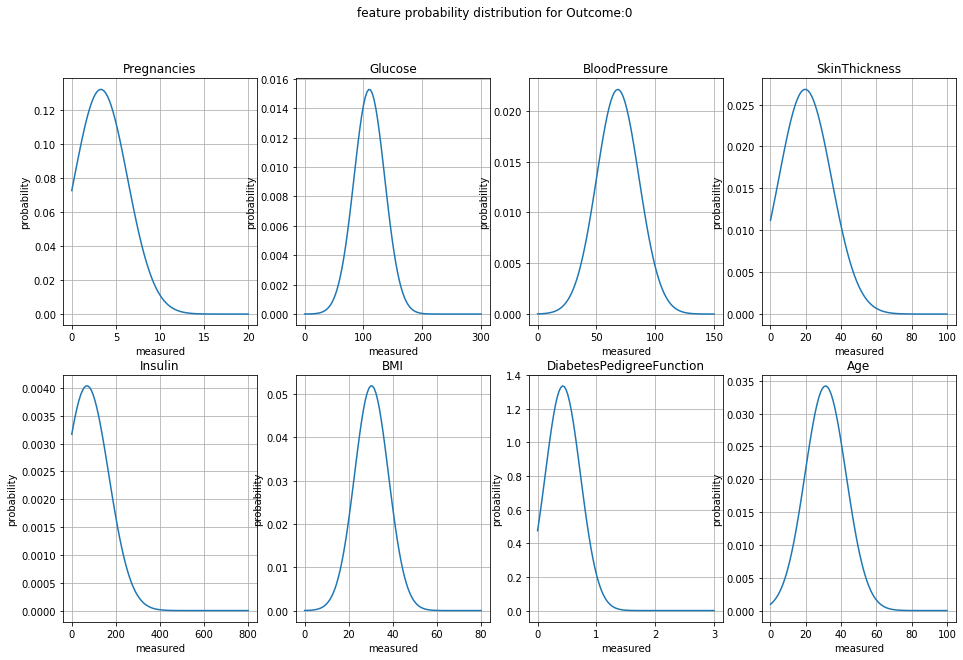

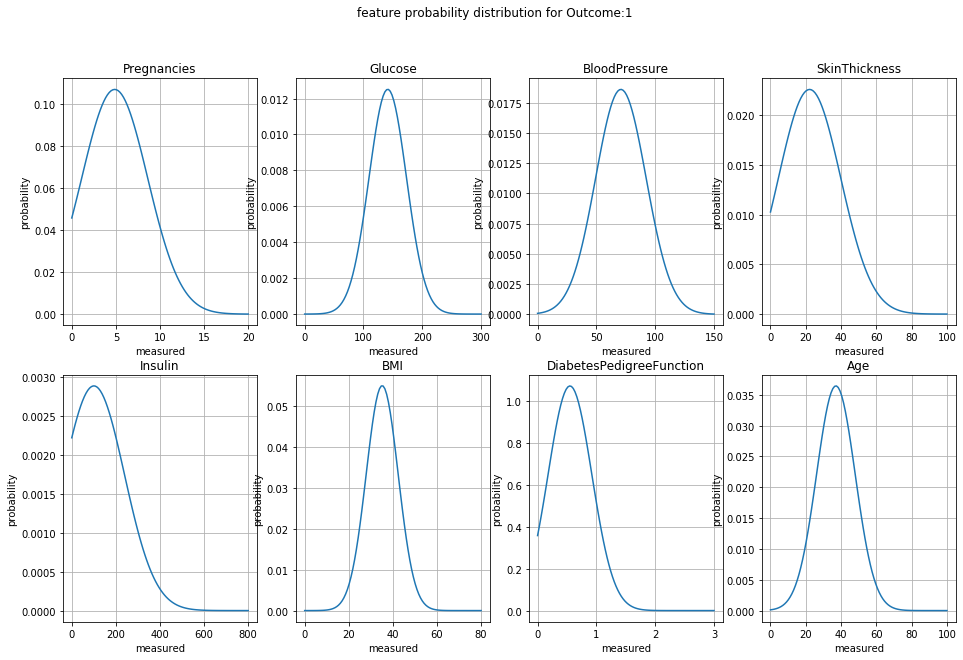

In [29]:
stops_per_feature = [20, 300, 150, 100, 800, 80, 3, 100]
def plot_feature_norm_for_a_target(thetas, sigmas, target, feature_names, target_name):
    fig = plt.figure(figsize = (16,10))
    fig.suptitle(f'feature probability distribution for {target_name}')
    for col in np.arange(len(feature_names)):
        x_arr = np.linspace(0, stops_per_feature[col], 100)
        y_arr = norm.pdf(x_arr, thetas[target, col], sigmas[target, col])
        plt.subplot(241 + col)
        plt.plot(x_arr, y_arr)
        plt.grid(True)
        plt.xlabel('measured')
        plt.ylabel('probability')
        plt.title(feature_names[col])
    plt.show()
    
for target in np.arange(len(separated.keys())):
    plot_feature_norm_for_a_target(thetas, sigmas, target, feature_names, target_names[target])

## 베이지안 추론

베이즈 정리에 기반하여 다음과 같이 세 단계를 거쳐 추론하는 것을 베이지안 추론이라고 합니다.

1. 기존의 믿음 (prior belief)
2. 새로운 증거 (new evidence)
3. 믿음의 수정 (update belief -> posterior belief)

### 베이즈 정리

베이즈 정리는 아래의 식으로 표현됩니다.

* $P(H|E) = \frac{P(E|H)\times P(H)}{P(E)}$

위 식에서 각 항목의 의미는 다음과 같습니다.

* $E$ : 사건 (event)
* $H$ : 추론하고자 하는 값 (hypothesis)
* $P(H)$ : E가 발생하기 전의 H에 대한 확률분포 (prior probability distribution)
* $P(E|H)$ : H를 알고 있을 때 E의 발생 가능도 (likelihood)
* $P(E)$ : H에 관계없이 E의  발생 가능도 (marginal likelihood)
* $P(H|E)$ : E가 발생한 후의 H에 대한 확률분포 (posterior probability distribution)

위의 식을 분류 문제에 적용하기 위하여 E와 H를 다음과 같이 정의합니다.

* E: 측정값 ($v_{measured}$)
* H: 측정값으로부터 추정하는 실제값 ($v_{actual}$)

측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$의 확률분포를 아래와 같이 조건부확률로 표현할 수 있습니다.

* $P(v_{actual}|v_{measured})$

이를 베이즈 정리에 따라 표현하면 아래와 같습니다.

* $P(v_{actual}|v_{measured})=\frac { P(v_{measured}|v_{actual})\times P(v_{actual}) }{ P(v_{measured}) }$

위 식의 각 항목에 대한 의미는 다음과 같습니다.

* $P(v_{actual})$ : 측정값을 알기 전의 실제값 $v_{actual}$에 대한 확률분포
* $P(v_{measured}|v_{actual})$ : 실제값이 $v_{actual}$일때 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{measured})$ : 실제값이 무엇이냐에 관계없이 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{actual}|v_{measured})$ : 측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$에 대한 확률분포

### 기존의 믿음

당뇨병 데이터세트로부터 얻은 당뇨병 발병 여부의 분포를 기존의 믿음으로 간주합니다. 즉 당뇨병 발병 여부가 알려지지 않은 새로운 환자가 있을 때 여덟 가지 속성의 값을 측정하기 전에는 그 환자의 당뇨병 발병 여부는 데이터 세트로부터 얻은 분포를 따른다고 믿는 것입니다. 이를 **사전확률(prior probability)**이라고 합니다.

In [30]:
def get_priors(separated):
    targets = separated.keys()

    priors = np.zeros(len(targets))
    
    total_count = 0
    for target in targets:
        count = separated[target].shape[0]
        total_count += count
        priors[target] = count
    
    priors /= total_count
    
    return priors

priors = get_priors(separated)
print(priors)

[0.651042 0.348958]


위의 결과는 새로운 환자에 대하여 측정을 하기 전까지는 아래의 확률로 당뇨병 발병 여부를 추정할 수 있음을 의미합니다.

* $P(target=0) = 0.651042$
* $P(target=1) = 0.348958$

### 새로운 증거

새로운 환자가 있고 여덟 가지 속성을 측정하여 얻은 값은 다음과 같다고 가정합니다.

| Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI | DiabetesPedigreeFunction | Age |
| -- | -- | -- | -- | -- | -- | -- | -- |
| 6 | 148 | 72 | 35 | 100 | 50 | 1 | 40 |

In [31]:
measured = np.array([[6, 148, 72, 35, 100, 50, 1, 40]])

실제값이 $target = t$일 때 속성별로 측정값 $m_1=v_1;m_2=v_2;m_3=v_3;m_4=v_4;m_5=v_5;m_6=v_6;m_7=v_7;m_8=v_8$을 얻을 가능성을 나타내는 **가능도(likelihood)**를 구합니다. 이때 각각의 특성은 서로 독립적이라고 가정하고 속성별로 확률을 계산합니다. 이러한 가정을 하기 때문에 **Bayes** 방식이라는 말 앞에 **Naive**를 덧붙여서 부릅니다. 

* $P(m_1=v_1;m_2=v_2;m_3=v_3;m_4=v_4;m_5=v_5;m_6=v_6;m_7=v_7;m_8=v_8|target=t) \\
\qquad = P(m_1=v_1|target=t) \\
\qquad \times P(m_2=v_2|target=t) \\
\qquad \times P(m_3=v_3|target=t) \\
\qquad \times P(m_4=v_4|target=t) \\
\qquad \times P(m_5=v_5|target=t) \\
\qquad \times P(m_6=v_6|target=t) \\
\qquad \times P(m_7=v_7|target=t) \\
\qquad \times P(m_8=v_8|target=t)$

In [32]:
def get_likelihoods(thetas, sigmas, measured):
    target_count = thetas.shape[0]
    instance_count = measured.shape[0]

    likelihoods = np.zeros((instance_count, target_count))
    
    for target in np.arange(target_count):
        l = norm.pdf(measured, thetas[target, :], sigmas[target, :])
        likelihoods[:, target] = np.prod(l, axis=1)
        
    return likelihoods

likelihoods = get_likelihoods(thetas, sigmas, measured)
print(likelihoods)

[[6.622313e-15 1.418506e-13]]


실제값이 무엇인지에 관계없이 측정값으로 $m_1=v_1;m_2=v_2;m_3=v_3;m_4=v_4;m_5=v_5;m_6=v_6;m_7=v_7;m_8=v_8$을 얻을 가능성을 나타내는 **주변가능도(marginal likelihood)**는 아래와 같이 구합니다.

* $P(m_1=v_1;m_2=v_2;m_3=v_3;m_4=v_4;m_5=v_5;m_6=v_6;m_7=v_7;m_8=v_8) \\
\qquad = P(m_1=v_1;m_2=v_2;m_3=v_3;m_4=v_4;m_5=v_5;m_6=v_6;m_7=v_7;m_8=v_8|target=0) \times P(target=0) \\
\qquad + P(m_1=v_1;m_2=v_2;m_3=v_3;m_4=v_4;m_5=v_5;m_6=v_6;m_7=v_7;m_8=v_8|target=1) \times P(target=1)$

In [33]:
marginal_likelihoods = np.sum(likelihoods * priors, axis=1)
print(marginal_likelihoods)

[5.381133e-14]


### 믿음의 수정

**새로운 증거(new evidence)**를 활용하여 **기존의 믿음(prior)**을 수정합니다. 이렇게 얻은 확률을 **사후확률 (posterior)**이라고 부릅니다. 측정값이 주어진 상태에서 발병 여부를 바꾸어 가면서 사후확률을 구합니다.

In [34]:
def get_posteriors(priors, thetas, sigmas, X):
    likelihoods = get_likelihoods(thetas, sigmas, X)
    marginal_likelihoods = np.sum(likelihoods * priors, axis=1)
    likelihood_ratios = likelihoods / marginal_likelihoods.reshape(len(marginal_likelihoods), -1)
    posteriors = likelihood_ratios * priors
    return posteriors

posteriors = get_posteriors(priors, thetas, sigmas, measured)
print(posteriors)

[[0.080121 0.919879]]


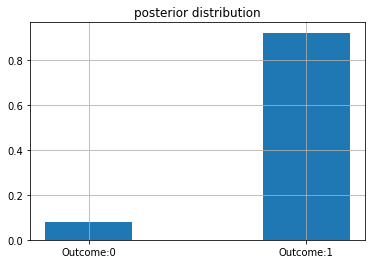

In [35]:
target_names_arr = ['Outcome:0', 'Outcome:1']
plt.figure(figsize = (6, 4))
plt.bar(target_names_arr, posteriors[0,:], width=0.4)
plt.grid(True)
plt.title('posterior distribution')
plt.show()

발병 여부별 사후확률 중에서 최대값에 해당하는 결과를 실제값으로 간주합니다. 이 과정을 **Maximum A Posteriori(MAP) 추정**이라고 부릅니다.

In [36]:
predicted = np.argmax(posteriors, axis=1)

for i in np.arange(measured.shape[0]):
    print(f'{measured[i,:]} => {target_names[predicted[i]]}')

[  6 148  72  35 100  50   1  40] => Outcome:1


## 분류기 구현

위에서 정의한 함수들을 사용하여 분류기 클래스를 아래와 같이 구현할 수 있습니다.

In [37]:
class GaussianNB:
    def fit(self, X, y):
        # separate by targets
        separated = separate_by_targets(X, y)
        
        # get priors
        self.priors = get_priors(separated)
        
        # get normal distribution parameters
        self.thetas, self.sigmas = get_norm_params(separated)
        
    def predict(self, X):
        posteriors = get_posteriors(self.priors, self.thetas, self.sigmas, X)
        predicted = np.argmax(posteriors, axis=1)
        return predicted
        
    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)

### 예측 성능

In [38]:
X, y = ds_diabetes.iloc[:,0:8].values, ds_diabetes.iloc[:,8].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

nb = GaussianNB()
nb.fit(X_train, y_train)

score = nb.score(X_test, y_test)
print(f'score = {score:.4f}')

score = 0.7532


## 마무리

* 이 글에서 구현한 분류기는 측정값이 정규분포를 따르는 다른 종류의 데이터세트에 대해서도 동작합니다.